In [1]:
import os
import pickle
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem
plt.style.use('default')

sys.path.append('/DATA/publish/mocet/analysis/scripts')
from utils.base import get_minecraft_subjects, get_project_directory, get_configs

subject_pool = get_minecraft_subjects()
project_dir = get_project_directory()
configs = get_configs()

calibration_onsets = configs['calibration_onsets']
calibration_points = configs['calibration_points']
interval = configs['interval']
task_duration = configs['task_duration']
task = configs['task']

calibration_offset_start = configs['calibration_offset_start']
calibration_offset_end = configs['calibration_offset_end']
px_per_deg = configs['px_per_deg']

valid_data = pickle.load(open('../../data/valid_data_list.pkl', 'rb'))
valid_keys = list(valid_data.keys())

experiment_folder = "/DATA/publish/mocet/analysis/data/DeepMReye"
functional_data = os.path.join("/DATA", "Minecraft_old", "_DATA", "fMRI")
processed_data = os.path.join(experiment_folder, "processed_data/")
model_weights = os.path.join(experiment_folder, "model_weights/")
model_results = os.path.join(experiment_folder, "results/")

calibration_coordinates = np.array([[200-800, 166-500], [200-800, 500-500], [200-800, 833-500],
                               [600-800, 166-500], [600-800, 500-500], [600-800, 833-500],
                               [1000-800, 166-500], [1000-800, 500-500], [1000-800, 833-500],
                               [1400-800, 166-500], [1400-800, 500-500], [1400-800, 833-500]]) * (1/px_per_deg)
calibration_coordinates = np.tile(calibration_coordinates, [2,1])
calibration_order = np.array([4,11,6,2,7,0,10,5,9,8,1,3]*2)
calibration_gt = calibration_coordinates[calibration_order, :]

scratch 0.5182349365573696 0.7198853634832213
finetuned 0.8862930605411098 0.9414313891841029


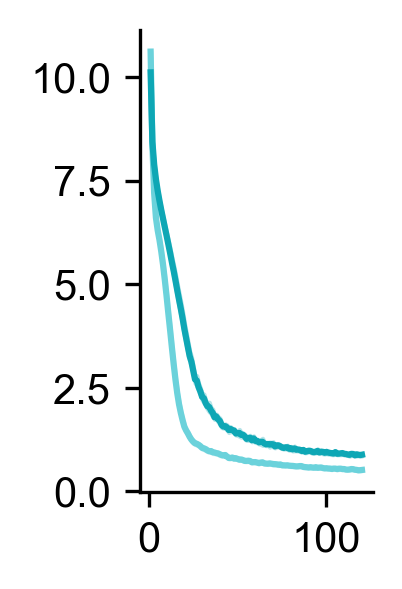

In [2]:
model_types = ['scratch', 'finetuned']

model_loss_history = []
for model_type in model_types:
    subject_loss = {}
    for key in valid_keys:
        subject, session, task, run = key
        if subject not in subject_loss:
            subject_loss[subject] = []
        loss_history = pd.read_csv(f'{model_weights}/{subject}_{session}_{run}_loss_{model_type}.txt')
        subject_loss[subject].append(np.array(loss_history['Training Loss']))

    for subject in subject_loss.keys():
        subject_loss[subject] = np.mean(subject_loss[subject], axis=0)

    subject_loss_mean = np.mean([subject_loss[subject] for subject in subject_loss], axis=0)
    subject_loss_se = sem([subject_loss[subject] for subject in subject_loss], axis=0)
    model_loss_history.append((subject_loss_mean, subject_loss_se))

plt.figure(figsize=(1,2), dpi=300)
ax = plt.gca()
model_colors = ['#6bd2db','#0ea7b5', '#0c457d']
for m, model_type in enumerate(model_types):
    ax.plot(np.arange(120)+1, model_loss_history[m][0], c=model_colors[m])
    ax.fill_between(np.arange(120)+1,
                     model_loss_history[m][0] - model_loss_history[m][1],
                     model_loss_history[m][0] + model_loss_history[m][1],
                     color=model_colors[m], alpha=0.3)
    print(model_type, model_loss_history[m][0][-1], np.sqrt( model_loss_history[m][0][-1]))
ax.spines[['right', 'top']].set_visible(False)
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")

In [5]:
model_type = 'pretrained'
subject_RMSEs = {}
for key in valid_keys:
    subject, session, task, run = key
    if subject not in subject_RMSEs.keys():
        subject_RMSEs[subject] = []
    pred_y = np.load(f'{model_results}/{subject}_{session}_{run}_pred_{model_type}.npy')

    t_val = 0
    test_RMSE = []
    correlation = []
    for t, time in enumerate(range(calibration_onsets[t_val], calibration_onsets[t_val] + calibration_points[t_val])):
        x_pred = pred_y[time,0]
        y_pred = pred_y[time,1]
        x_data = calibration_gt[t,0] #np.mean(calibration_x[t*10:(t+1)*10])
        y_data = calibration_gt[t,1] #np.mean(calibration_y[t*10:(t+1)*10])
        test_RMSE.append(np.sqrt((x_pred-x_data)**2 + (y_pred-y_data)**2))
        correlation.append([x_pred, x_data, y_pred, y_data])
    correlation = np.array(correlation)
    subject_RMSEs[subject].append(np.mean(test_RMSE))

for subject in subject_loss.keys():
    subject_RMSEs[subject] = np.mean(subject_RMSEs[subject], axis=0)

print(model_type, np.mean(list(subject_RMSEs.values())))

pretrained 6.193161599070392


In [10]:
from scipy.stats import pearsonr
import mocet

def resample_gaze_data(gaze_timestamp, gaze_coordinate, interval=20):
    new_time_series = np.arange(0, gaze_timestamp[-1] + interval, interval)
    resampled_gaze = np.zeros((len(new_time_series), 2))
    resampled_gaze[:, 0] = np.interp(new_time_series, gaze_timestamp, gaze_coordinate[:, 0])
    resampled_gaze[:, 1] = np.interp(new_time_series, gaze_timestamp, gaze_coordinate[:, 1])
    return new_time_series, resampled_gaze


model_pred = []
model_RMSEs = []
model_x_corr = []
model_y_corr = []
model_deviation = []

subject_pred = {}
subject_RMSEs = {}
subject_x_corr = {}
subject_y_corr = {}
subject_deviation = {}
for key in valid_keys:
    subject, session, task, run = key
    if subject not in subject_RMSEs:
        subject_pred[subject] = []
        subject_RMSEs[subject] = []
        subject_x_corr[subject] = []
        subject_y_corr[subject] = []
    gaze_root = f'../../data/corrected_eyetracking/mocet/{subject}/{session}'
    gaze_timestamp = np.load(f'{gaze_root}/{subject}_{session}_{task}_{run}_gaze_timestamp.npy')
    gaze_coordinate = np.load(f'{gaze_root}/{subject}_{session}_{task}_{run}_gaze_coordinate.npy')

    data_root = f'{project_dir}/data/eyetracking/{subject}/{session}'
    log_fname = f'{data_root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_log.csv'
    data_fname = f'{data_root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_dat.txt'
    history_fname = f'{data_root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_his.txt'
    start, _, _ = mocet.utils.get_viewpoint_history(history_fname)
    _, _, pupil_confidence, _ = mocet.utils.clean_viewpoint_data(log_fname,
                                                                 data_fname,
                                                                 start=start,
                                                                 duration=task_duration)

    # need to resample the gaze data
    new_time_series, resampled_gaze = resample_gaze_data(gaze_timestamp, gaze_coordinate)
    resampled_gaze[:, 0] -= 800
    resampled_gaze[:, 1] -= 500
    subject_pred[subject].append(resampled_gaze[:40780, :] / px_per_deg)  #time, (x, y)

    t_val = 1
    test_RMSE = []
    correlation = []
    for t, time in enumerate(range(calibration_onsets[t_val], calibration_onsets[t_val] + calibration_points[t_val])):
        ref_x = calibration_gt[t, 0] * px_per_deg  #np.mean(calibration_x[t*10:(t+1)*10])
        ref_y = calibration_gt[t, 1] * px_per_deg

        start = (time) * interval + calibration_offset_start
        end = (time + 1) * interval + calibration_offset_end
        gaze_idx_start = np.min(np.where(gaze_timestamp >= start * 1000)[0])
        gaze_idx_end = np.min(np.where(gaze_timestamp >= end * 1000)[0])
        eye_closed = np.isnan(pupil_confidence[gaze_idx_start:gaze_idx_end])
        if np.any(~eye_closed):
            data_x = np.nanmean(gaze_coordinate[gaze_idx_start:gaze_idx_end, 0][~eye_closed]) - 800
            data_y = np.nanmean(gaze_coordinate[gaze_idx_start:gaze_idx_end, 1][~eye_closed]) - 500
            test_RMSE.append(np.sqrt((ref_x - data_x) ** 2 + (ref_y - data_y) ** 2) / px_per_deg)
            correlation.append([data_x, ref_x, data_y, ref_y])
    correlation = np.array(correlation)
    subject_RMSEs[subject].append(np.mean(test_RMSE))
    subject_x_corr[subject].append(pearsonr(correlation[:, 0], correlation[:, 1])[0])
    subject_y_corr[subject].append(pearsonr(correlation[:, 2], correlation[:, 3])[0])

for subject in subject_RMSEs.keys():
    subject_deviation[subject] = np.mean([np.sqrt(pred[:, 0] ** 2 + pred[:, 1] ** 2) for pred in subject_pred[subject]],
                                         axis=0)
    subject_pred[subject] = np.mean(subject_pred[subject], axis=0)
    subject_RMSEs[subject] = np.mean(subject_RMSEs[subject], axis=0)
    subject_x_corr[subject] = np.mean(subject_x_corr[subject], axis=0)
    subject_y_corr[subject] = np.mean(subject_y_corr[subject], axis=0)

model_pred.append(np.array(list(subject_pred.values())))
model_RMSEs.append(list(subject_RMSEs.values()))
model_x_corr.append(list(subject_x_corr.values()))
model_y_corr.append(list(subject_y_corr.values()))
model_deviation.append(np.array(list(subject_deviation.values())))

print(np.mean(model_RMSEs))
print(np.mean(model_x_corr))
print(np.mean(model_y_corr))

1.2140012660711195
0.9912079337765685
0.9683967660132313


In [24]:
model_types = ['scratch', 'finetuned', 'pretrained']
for model_type in model_types:
    subject_pred = {}
    subject_RMSEs = {}
    subject_x_corr = {}
    subject_y_corr = {}
    for key in valid_keys:
        subject, session, task, run = key
        if subject not in subject_pred:
            subject_pred[subject] = []
            subject_RMSEs[subject] = []
            subject_x_corr[subject] = []
            subject_y_corr[subject] = []
        pred_y = np.load(f'{model_results}/{subject}_{session}_{run}_pred_{model_type}.npy')
        subject_pred[subject].append(pred_y)

        t_val = 1
        test_RMSE = []
        correlation = []
        for t, time in enumerate(range(calibration_onsets[t_val], calibration_onsets[t_val] + calibration_points[t_val])):
            x_pred = pred_y[time,0]
            y_pred = pred_y[time,1]
            x_data = calibration_gt[t,0] #np.mean(calibration_x[t*10:(t+1)*10])
            y_data = calibration_gt[t,1] #np.mean(calibration_y[t*10:(t+1)*10])
            test_RMSE.append(np.sqrt((x_pred-x_data)**2 + (y_pred-y_data)**2))
            correlation.append([x_pred, x_data, y_pred, y_data])
        correlation = np.array(correlation)
        subject_RMSEs[subject].append(np.mean(test_RMSE))
        subject_x_corr[subject].append(pearsonr(correlation[:,0], correlation[:,1])[0])
        subject_y_corr[subject].append(pearsonr(correlation[:,2], correlation[:,3])[0])

    for subject in subject_pred.keys():
        subject_pred[subject] = np.mean(subject_pred[subject], axis=0)
        subject_RMSEs[subject] = np.mean(subject_RMSEs[subject], axis=0)
        subject_x_corr[subject] = np.mean(subject_x_corr[subject], axis=0)
        subject_y_corr[subject] = np.mean(subject_y_corr[subject], axis=0)
    model_pred.append(np.array(list(subject_pred.values())))
    model_RMSEs.append(list(subject_RMSEs.values()))
    model_x_corr.append(list(subject_x_corr.values()))
    model_y_corr.append(list(subject_y_corr.values()))

    print(np.mean(list(subject_RMSEs.values())), np.mean(list(subject_x_corr.values())), np.mean(list(subject_y_corr.values())))

5.5214901779872525 0.5743084548857704 0.6239653617126278
5.525893309923895 0.56263078392791 0.42184376881413754
6.184952818035336 0.44379303075065585 -0.003970331110085842


(4, 18)


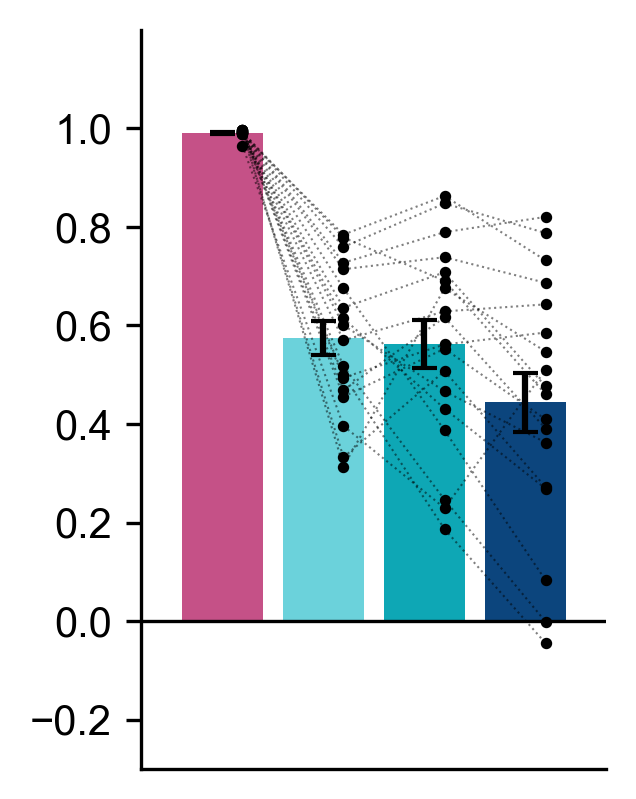

In [13]:
from scipy.stats import sem, ttest_rel, ttest_ind
plt.style.use('default')

MSE_matrix = np.concatenate([
    np.array(model_x_corr[i]).reshape(1,-1) for i in range(4)], axis=0)
print(MSE_matrix.shape)

#color_list = ['#c55187']+['#5e997d']*3+['#444444']
color_list = ['#c55187','#6bd2db','#0ea7b5', '#0c457d']

fig, ax = plt.subplots(1, 1, figsize=(2,3.2), dpi=300,  sharex=True)
ax.bar(np.arange(1+2+1),
       np.mean(MSE_matrix, axis=1),
       yerr=sem(MSE_matrix, axis=1),
       capsize=3, color=color_list)

# # Add scatter points to the box plot
for i in range(1+2+1):
    ax.scatter(np.ones(MSE_matrix.shape[1]) * (i) + 0.2, MSE_matrix[i], s=3, c='k')

# Connect the scatter points
for s in range(MSE_matrix.shape[1]):
    for i in range(1+2):
        ax.plot([i+0.2, i+1+0.2], [MSE_matrix[i, s], MSE_matrix[i+1, s]], c='k', linestyle=':', lw=0.5, alpha=0.5)

ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([])
ax.set_xlim(-0.8, 3.8)
ax.set_ylim(-0.3, 1.2)
ax.set_yticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.axhline(0, c='k', lw=0.8, linestyle='-')
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")

(4, 18)


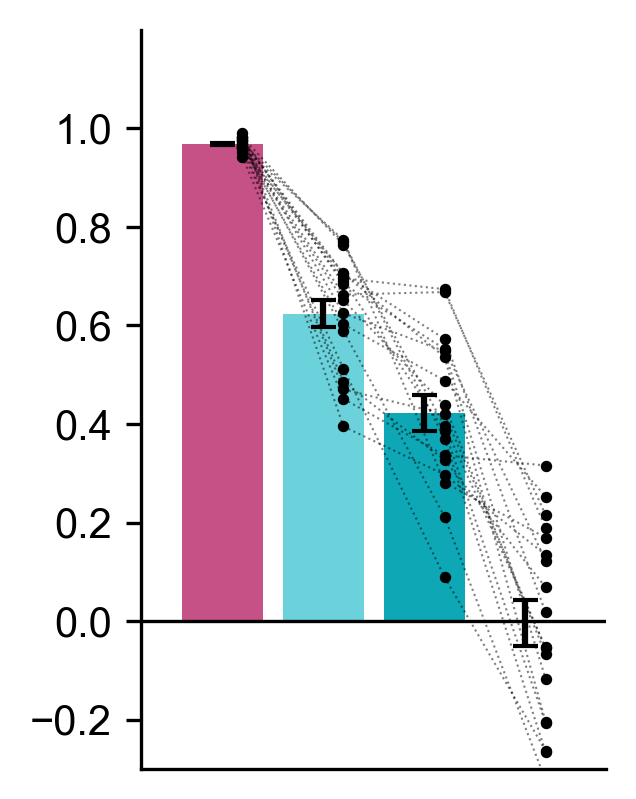

In [14]:
MSE_matrix = np.concatenate([
    np.array(model_y_corr[i]).reshape(1,-1) for i in range(4)], axis=0)
print(MSE_matrix.shape)

#color_list = ['#c55187']+['#5e997d']*3+['#444444']
color_list = ['#c55187','#6bd2db','#0ea7b5', '#0c457d']

fig, ax = plt.subplots(1, 1, figsize=(2,3.2), dpi=300,  sharex=True)
ax.bar(np.arange(1+2+1),
       np.mean(MSE_matrix, axis=1),
       yerr=sem(MSE_matrix, axis=1),
       capsize=3, color=color_list)

# # Add scatter points to the box plot
for i in range(1+2+1):
    ax.scatter(np.ones(MSE_matrix.shape[1]) * (i) + 0.2, MSE_matrix[i], s=3, c='k')

# Connect the scatter points
for s in range(MSE_matrix.shape[1]):
    for i in range(1+2):
        ax.plot([i+0.2, i+1+0.2], [MSE_matrix[i, s], MSE_matrix[i+1, s]], c='k', linestyle=':', lw=0.5, alpha=0.5)

ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([])
ax.set_xlim(-0.8, 3.8)
ax.set_ylim(-0.3, 1.2)
ax.set_yticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.axhline(0, c='k', lw=0.8, linestyle='-')
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")

(4, 18)


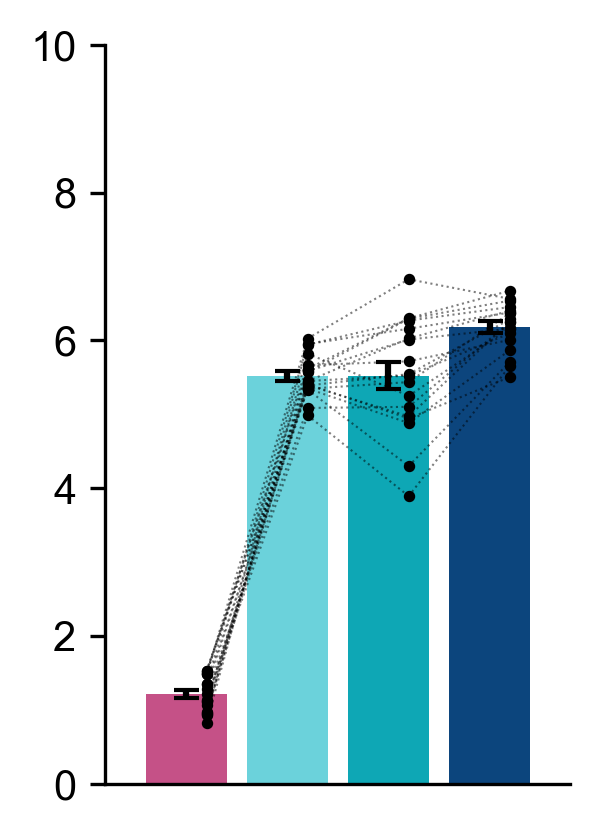

In [15]:
MSE_matrix = np.concatenate([
    np.array(model_RMSEs[i]).reshape(1,-1) for i in range(4)], axis=0)
print(MSE_matrix.shape)

#color_list = ['#c55187']+['#5e997d']*3+['#444444']
color_list = ['#c55187','#6bd2db','#0ea7b5', '#0c457d']

fig, ax = plt.subplots(1, 1, figsize=(2,3.2), dpi=300,  sharex=True)
ax.bar(np.arange(1+2+1),
       np.mean(MSE_matrix, axis=1),
       yerr=sem(MSE_matrix, axis=1),
       capsize=3, color=color_list)

# # Add scatter points to the box plot
for i in range(1+2+1):
    ax.scatter(np.ones(MSE_matrix.shape[1]) * (i) + 0.2, MSE_matrix[i], s=3, c='k')

# Connect the scatter points
for s in range(MSE_matrix.shape[1]):
    for i in range(1+2):
        ax.plot([i+0.2, i+1+0.2], [MSE_matrix[i, s], MSE_matrix[i+1, s]], c='k', linestyle=':', lw=0.5, alpha=0.5)

ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([])
ax.set_xlim(-0.8, 3.8)
ax.set_ylim(None, 10)
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")

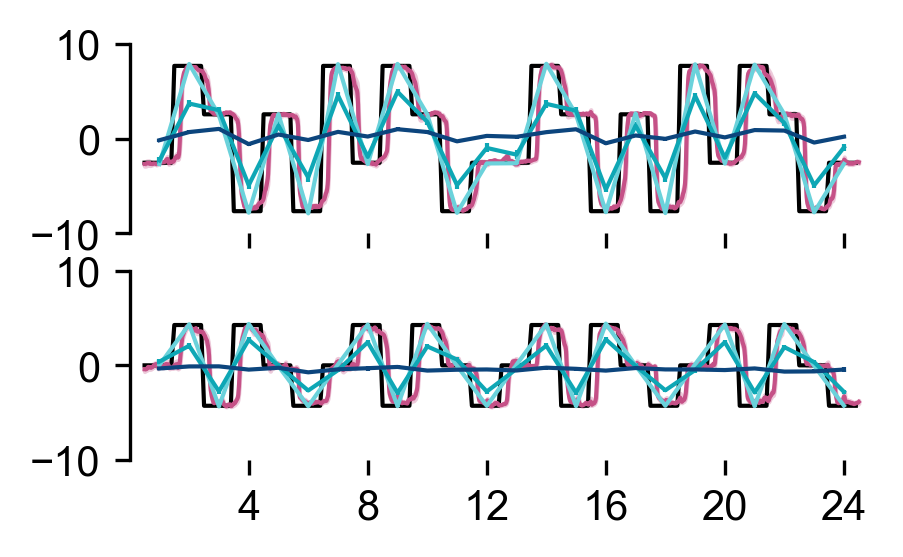

In [16]:
# draw the group-averaged pred_y with standard error band across subjects

calibration_time = np.arange(0,24,0.1)
calibration_x = np.zeros(240)
calibration_y = np.zeros(240)
for t, time in enumerate(calibration_time):
    x = calibration_gt[int(np.floor(time)), 0]
    y = calibration_gt[int(np.floor(time)), 1]
    calibration_x[t] = x
    calibration_y[t] = y

time_sta = 1
time_end = time_sta + 24

# Plot with error bands
fig, axes = plt.subplots(2, 1, figsize=(3.2, 1.8), dpi=300, sharex=True, sharey=True)

axes[0].plot(calibration_time + time_sta, calibration_x, c='#000000', lw=1,)
axes[1].plot(calibration_time + time_sta, calibration_y, c='#000000', lw=1,)

for m in range(4):
    if m == 0:
        # plotting MoCET
        time_sta_idx = int(time_sta*1600 / 20)
        time_end_idx = int(time_end*1600 / 20)
        group_pred = np.mean(model_pred[0], axis=0)
        group_pred_se = sem(model_pred[0], axis=0)
        for i in range(2):
            axes[i].plot(np.linspace(time_sta, time_end, int(24*50*1.6)), group_pred[time_sta_idx:time_end_idx, i],
                         c=color_list[m], lw=1, alpha=1.0)
            axes[i].fill_between(np.linspace(time_sta, time_end, int(24*50*1.6)),
                                 group_pred[time_sta_idx:time_end_idx, i] - group_pred_se[time_sta_idx:time_end_idx, i],
                                 group_pred[time_sta_idx:time_end_idx, i] + group_pred_se[time_sta_idx:time_end_idx, i],
                                 color=color_list[m], alpha=0.3)
    else:
        group_pred = np.mean(model_pred[m], axis=0)
        group_pred_se = sem(model_pred[m], axis=0)
        for i in range(2):
            axes[i].errorbar(np.arange(time_sta, time_end) + 0.5,
                                 group_pred[time_sta:time_end, i],
                                 yerr=group_pred_se[time_sta:time_end, i],
                                 color=color_list[m], alpha=1.0, lw=1)
axes[0].set_xlim(0.5, 25+0.5)
for ax in [axes[0], axes[1]]:
    #ax.axhline(0, c='k', lw=0.8)
    ax.set_ylim(-10, 10)
    ax.set_xlim(time_sta-0.5, time_end+0.5)
    ax.spines[['top', 'bottom', 'right']].set_visible(False)
    for tick in ax.get_yticklabels():
        tick.set_fontname("Arial")
    for tick in ax.get_xticklabels():
        tick.set_fontname("Arial")
plt.xticks(np.array([4,8,12,16,20,24])+0.5, [4,8,12,16,20,24])
plt.show()

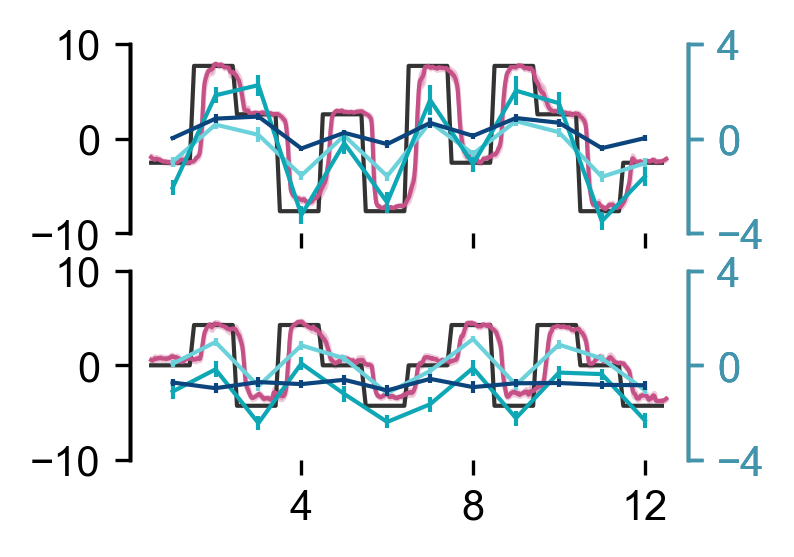

In [17]:
# draw the group-averaged pred_y with standard error band across subjects
time_sta = 494
time_end = time_sta + 12

# Plot with error bands
fig, axes = plt.subplots(2, 1, figsize=(2.4, 1.8), dpi=300, sharex=True, sharey=True)

axes[0].plot(calibration_time[:120] + time_sta, calibration_x[:120], c='#333333', lw=1)
axes[1].plot(calibration_time[:120] + time_sta, calibration_y[:120], c='#333333', lw=1)

for m in range(4):
    if m == 0:
        # plotting MoCET
        time_sta_idx = int(time_sta * 1600 / 20)
        time_end_idx = int(time_end * 1600 / 20)
        group_pred = np.mean(model_pred[0], axis=0)
        group_pred_se = sem(model_pred[0], axis=0)
        for i in range(2):
            axes[i].plot(np.linspace(time_sta, time_end, int(12 * 50 * 1.6)), group_pred[time_sta_idx:time_end_idx, i],
                         c=color_list[m], lw=1, alpha=1.0)
            axes[i].fill_between(np.linspace(time_sta, time_end, int(12 * 50 * 1.6)),
                                 group_pred[time_sta_idx:time_end_idx, i] - group_pred_se[time_sta_idx:time_end_idx, i],
                                 group_pred[time_sta_idx:time_end_idx, i] + group_pred_se[time_sta_idx:time_end_idx, i],
                                 color=color_list[m], alpha=0.3)
    else:
        group_pred = np.mean(model_pred[m], axis=0)
        group_pred_se = sem(model_pred[m], axis=0)
        for i in range(2):
            ax2 = axes[i].twinx()  # Create a secondary y-axis
            ax2.errorbar(np.arange(time_sta, time_end) + 0.5,
                         group_pred[time_sta:time_end, i],
                         yerr=group_pred_se[time_sta:time_end, i],
                         color=color_list[m], alpha=1.0, lw=1)
            ax2.set_ylim(-4, 4)  # Adjust the scale for the secondary y-axis
            ax2.set_yticks([-4, 0, 4])
            ax2.spines['right'].set_color('#4294ac')
            ax2.tick_params(axis='y', colors='#4294ac')
            ax2.spines[['top', 'bottom']].set_visible(False)
            for tick in ax2.get_yticklabels():
                tick.set_fontname("Arial")
            for tick in ax2.get_xticklabels():
                tick.set_fontname("Arial")
            #ax2.set_ylabel('Scaled Value', color=color_list[m])

for ax in [axes[0], axes[1]]:
    #ax.axhline(0, c='k', lw=0.8)
    ax.set_ylim(-10, 10)
    ax.set_xlim(time_sta-0.5, time_end+0.5)
    ax.spines[['top', 'bottom']].set_visible(False)
    for tick in ax.get_yticklabels():
        tick.set_fontname("Arial")
    for tick in ax.get_xticklabels():
        tick.set_fontname("Arial")
plt.xticks(np.array([4,8,12])+time_sta-1+0.5, [4,8,12])
plt.show()

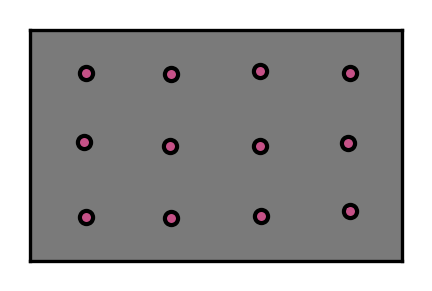

In [18]:
time_sta = 1
time_end = time_sta + 12

m = 0
plt.figure(figsize=(1.6, 1), dpi=300)
for t in range(time_sta, time_end):
    time_sta_idx = int(t*1600 / 20) + 30
    time_end_idx = int((t+1)*1600 / 20) - 30
    plt.errorbar(np.mean(model_pred[m][:, time_sta_idx:time_end_idx, 0].mean(axis=1)),
                 np.mean(model_pred[m][:, time_sta_idx:time_end_idx, 1].mean(axis=1)),
                 xerr=sem(model_pred[m][:, time_sta_idx:time_end_idx, 0].mean(axis=1)),
                 yerr=sem(model_pred[m][:, time_sta_idx:time_end_idx, 1].mean(axis=1)),
                c=color_list[m])
    plt.scatter(np.mean(model_pred[m][:, time_sta_idx:time_end_idx, 0].mean(axis=1)),
                 np.mean(model_pred[m][:, time_sta_idx:time_end_idx, 1].mean(axis=1)),
                s=10, color=color_list[m], edgecolor='k')
plt.xlim(-10.5, 10.5)
plt.ylim(-6.4, 6.4)
plt.xticks([])
plt.yticks([])
plt.gca().set_facecolor('#7a7a7a')
#plt.gca().spines[['top', 'bottom', 'left', 'right']].set_visible(False)
plt.show()


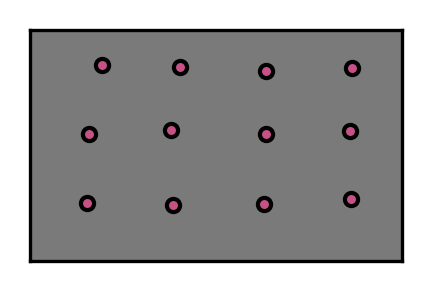

In [19]:
time_sta = 494
time_end = time_sta + 12

m = 0
plt.figure(figsize=(1.6, 1), dpi=300)
for t in range(time_sta, time_end):
    time_sta_idx = int(t*1600 / 20) + 30
    time_end_idx = int((t+1)*1600 / 20) - 30
    plt.errorbar(np.mean(model_pred[m][:, time_sta_idx:time_end_idx, 0].mean(axis=1)),
                 np.mean(model_pred[m][:, time_sta_idx:time_end_idx, 1].mean(axis=1)),
                 xerr=sem(model_pred[m][:, time_sta_idx:time_end_idx, 0].mean(axis=1)),
                 yerr=sem(model_pred[m][:, time_sta_idx:time_end_idx, 1].mean(axis=1)),
                c=color_list[m])
    plt.scatter(np.mean(model_pred[m][:, time_sta_idx:time_end_idx, 0].mean(axis=1)),
                 np.mean(model_pred[m][:, time_sta_idx:time_end_idx, 1].mean(axis=1)),
                s=10, color=color_list[m], edgecolor='k', zorder=10)
plt.xlim(-10.5, 10.5)
plt.ylim(-6.4, 6.4)
plt.xticks([])
plt.yticks([])
plt.gca().set_facecolor('#7a7a7a')
plt.show()


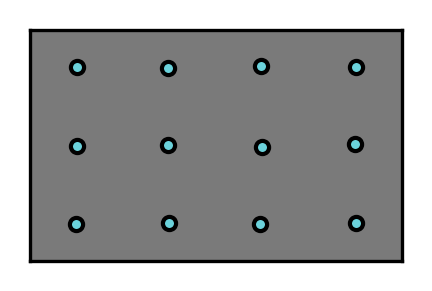

In [20]:
time_sta = 1
time_end = time_sta + 12

m = 1
plt.figure(figsize=(1.6, 1), dpi=300)
for t in range(time_sta, time_end):
    plt.errorbar(np.mean(model_pred[m][:, t, 0]),
                 np.mean(model_pred[m][:, t, 1]),
                 xerr=sem(model_pred[m][:, t, 0]),
                 yerr=sem(model_pred[m][:, t, 1]),
                c=color_list[m])
    plt.scatter(np.mean(model_pred[m][:, t, 0]),
                 np.mean(model_pred[m][:, t, 1]),
                s=10, color=color_list[m], edgecolor='k', zorder=10)
plt.xlim(-10.5, 10.5)
plt.ylim(-6.4, 6.4)
plt.xticks([])
plt.yticks([])
plt.gca().set_facecolor('#7a7a7a')
plt.show()

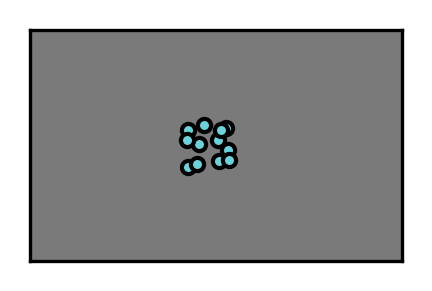

In [21]:
time_sta = 494
time_end = time_sta + 12

m = 1
plt.figure(figsize=(1.6, 1), dpi=300)
for t in range(time_sta, time_end):

    plt.errorbar(np.mean(model_pred[m][:, t, 0]),
                 np.mean(model_pred[m][:, t, 1]),
                 xerr=sem(model_pred[m][:, t, 0]),
                 yerr=sem(model_pred[m][:, t, 1]),
                c=color_list[m])
    plt.scatter(np.mean(model_pred[m][:, t, 0]),
                 np.mean(model_pred[m][:, t, 1]),
                s=10, color=color_list[m], edgecolor='k', zorder=10)
plt.xlim(-10.5, 10.5)
plt.ylim(-6.4, 6.4)
plt.xticks([])
plt.yticks([])
plt.gca().set_facecolor('#7a7a7a')
plt.show()